In [1]:
import os
import csv
import obspy


cwd = os.getcwd()
DATA_PATH = f'{cwd}/kik_knet_data'
TEST_DATA_PATH = f'{DATA_PATH}/test_data'
RAW_DATA_PATH = f'{TEST_DATA_PATH}/20180618075800'

In [2]:
def satisfied_condition(filename, include_all=False):
    if '.ps' in filename: return False
    if not include_all:
        accepted_exts = ['EW', 'NS', 'UD', 'EW2', 'NS2', 'UD2']
        ext = filename.split('.')[1]
        if ext not in accepted_exts: return False
    return True

event_folders = os.listdir(RAW_DATA_PATH)
folder_files = {}
for folder_name in event_folders:
    folder_path = f'{RAW_DATA_PATH}/{folder_name}'
    files = os.listdir(folder_path)
    folder_files[folder_name] = [
        f'{folder_path}/{file_name}' \
        for file_name in files if satisfied_condition(file_name)
    ]

print(len(folder_files))
# 40 stations close to OSK002 and less than or equal 50km epicentral distance.
# paper used closest 35

40


In [3]:
from obspy.core import Stream
def get_event_streams(event_name):
    st = Stream()
    files_paths = folder_files[event_name]
    for file_path in files_paths:
        stream = obspy.read(file_path, format="knet", apply_calib=True)
        trace = stream[0]
        tr_new = trace.copy()
        if tr_new.stats.sampling_rate == 200:
            tr_new.decimate(factor=2, strict_length=False)
        st += tr_new
    return st

In [4]:
events_streams = {}
for event_name in event_folders:
    streams = get_event_streams(event_name)
    events_streams[event_name] = streams
print(len(events_streams))

40


In [5]:
import pickle
def save_streams(name, data):
    with open(f'{name}.pkl', 'wb') as f:
        pickle.dump(data, f)

def load_streams(name):
    with open(f'{name}.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)
    return loaded_dict

In [6]:
save_streams('test.all_events_streams', events_streams)

In [7]:
events_streams = load_streams('test.all_events_streams')

In [8]:
from obspy.signal.trigger import ar_pick
def find_pswave_onset(data):
    df = data[0].stats.sampling_rate
    p_pick, s_pick = ar_pick(
        data[0].data,
        data[1].data,
        data[2].data,
        df,
        1.0, 20.0, 1.0, 0.1, 4.0, 1.0, 2, 8, 0.1, 0.2
    )
    return (p_pick, s_pick)

In [9]:
from obspy.core import Stream
ONE_SEC = 1
def extract_one_sec_of_pwave(pstart, stream):
    one_sec_pwave_stream = Stream()
    for tr in stream:
        dt = tr.stats.delta
        starttime = stream[0].stats.starttime
        pstarttime = starttime + pstart
        one_sec_pwave_stream += tr.slice(pstarttime, pstarttime + ONE_SEC - dt)
    return one_sec_pwave_stream

In [10]:
from obspy.core import Stream

test_onesec_pwave_events_streams = {}
test_filtered_onesec__pwave_events_streams = {}
for event in events_streams:
    data = events_streams[event]
    pw_onset, sw_onset = find_pswave_onset(data)
    test_onesec_pwave_events_streams[event] = \
        extract_one_sec_of_pwave(pw_onset, data)
    test_filtered_onesec__pwave_events_streams[event] = \
        extract_one_sec_of_pwave(pw_onset, data).filter(
            'bandpass', freqmin=10, freqmax=20)

save_streams('test.onesec_pwave_events_streams', test_onesec_pwave_events_streams)
save_streams('test.filtered_onesec_pwave_events_streams', test_filtered_onesec__pwave_events_streams)

In [11]:
import numpy as np
def create_ss_waveform_data(stream):
    matrix = np.array([tr.data for tr in stream])
    return np.sqrt(np.sum(np.square(matrix), axis=0))

In [12]:
geo_means = {}
for event in test_onesec_pwave_events_streams:
    st = test_onesec_pwave_events_streams[event]
    geo_mean = create_ss_waveform_data(st)
    geo_means[event] = geo_mean

save_streams('test.one_sec_geo_means', geo_means)

In [13]:
import numpy as np
from obspy.core import Stream
def create_absolute_stream(stream):
    abs_traces = []
    for tr in stream:
        abs_trace = tr.copy()
        abs_trace.data = np.abs(tr.data)
        abs_traces.append(abs_trace)
    return Stream(traces=abs_traces)

In [14]:
abs_one_sec_pwave_events_streams = {}
for event in test_onesec_pwave_events_streams:
    st = test_onesec_pwave_events_streams[event]
    one_sec_abs_pwave_stream = create_absolute_stream(st)
    abs_one_sec_pwave_events_streams[event] = one_sec_abs_pwave_stream

save_streams('test.abs_one_sec_pwave_events_streams', abs_one_sec_pwave_events_streams)

In [15]:
import numpy as np
from obspy.core import Stream
def create_cumabs_stream(abs_stream):
    cumabs_traces = []
    for tr in abs_stream:
        cumabs_trace = tr.copy()
        cumabs_trace.data = np.cumsum(tr.data)
        cumabs_traces.append(cumabs_trace)
    return Stream(traces=cumabs_traces)

In [16]:
cumabs_one_sec_pwave_events_streams = {}
for event in abs_one_sec_pwave_events_streams:
    st = abs_one_sec_pwave_events_streams[event]
    one_sec_cumabs_pwave_stream = create_cumabs_stream(st)
    cumabs_one_sec_pwave_events_streams[event] = one_sec_cumabs_pwave_stream

save_streams('test.cumabs_one_sec_pwave_events_streams', cumabs_one_sec_pwave_events_streams)

## create plots for near source: OSK0021806180758

In [20]:
# load onesec pwave data here, if not available
import pickle
def load_streams(name):
    with open(f'{name}.pkl', 'rb') as f:
        loaded_dict = pickle.load(f)
    return loaded_dict

all_events_streams = load_streams('test.all_events_streams')
one_sec_pwave_events_streams = load_streams('test.onesec_pwave_events_streams')
filtered_one_sec_pwave_events_streams = load_streams('test.filtered_onesec_pwave_events_streams')
abs_one_sec_pwave_events_streams = load_streams('test.abs_one_sec_pwave_events_streams')
cumabs_one_sec_pwave_events_streams = load_streams('test.cumabs_one_sec_pwave_events_streams')
geo_means = load_streams('test.one_sec_geo_means')

In [21]:
def create_station_dict(station_name, normalize=False):
    all = all_events_streams[station_name].copy()
    one_sec_acc = one_sec_pwave_events_streams[station_name].copy()
    one_sec_filt = filtered_one_sec_pwave_events_streams[station_name].copy()
    one_sec_abs = abs_one_sec_pwave_events_streams[station_name].copy()
    one_sec_cumabs = cumabs_one_sec_pwave_events_streams[station_name].copy()

    one_sec_acc = one_sec_acc.normalize() if normalize else one_sec_acc
    one_sec_filt = one_sec_filt.normalize() if normalize else one_sec_filt
    one_sec_abs = one_sec_abs.normalize() if normalize else one_sec_abs
    one_sec_cumabs = one_sec_cumabs.normalize() if normalize else one_sec_cumabs

    return {
        'all_time_acc': all,
        'one_sec_acc': one_sec_acc,
        'one_sec_filt_acc': one_sec_filt,
        'one_sec_abs_acc': one_sec_abs,
        'one_sec_cumabs_acc': one_sec_cumabs,
    }

In [22]:
# Where to save the figures
import os
PROJECT_ROOT_DIR = "."
NAME = "kik_knet"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", NAME)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [24]:
osaka002 = all_events_streams['OSK0021806180758']

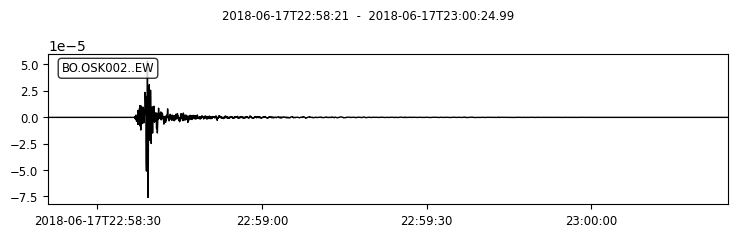

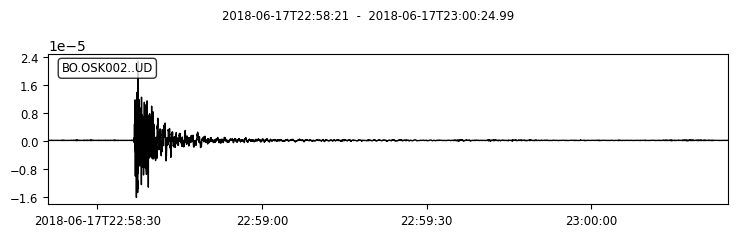

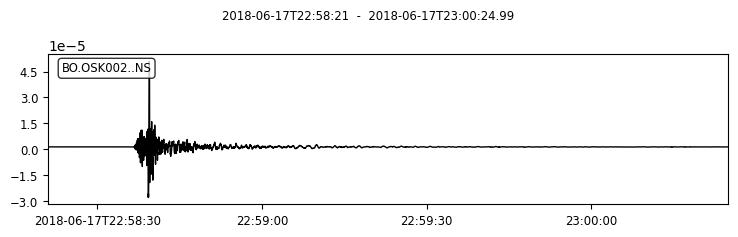

In [25]:
for tr in osaka002:
    tr.plot()

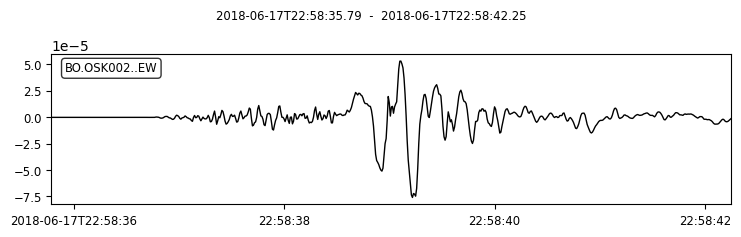

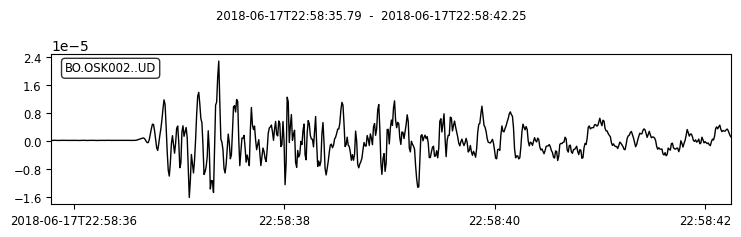

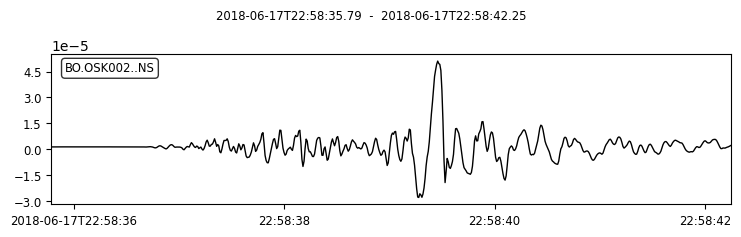

In [26]:
pw_onset, sw_onset = find_pswave_onset(osaka002)
# pw_onset = 15.x
# sw_onset = 18.x
osaka002_stream_15_to_21 = Stream()
for tr in osaka002:
    dt = tr.stats.delta
    starttime = osaka002[0].stats.starttime
    pstarttime = starttime + pw_onset
    sstarttime = starttime + sw_onset
    osaka002_stream_15_to_21 += tr.slice(pstarttime - 1, sstarttime + 3)

for tr in osaka002_stream_15_to_21:
    tr.plot()

Saving figure osaka002_15_to_21


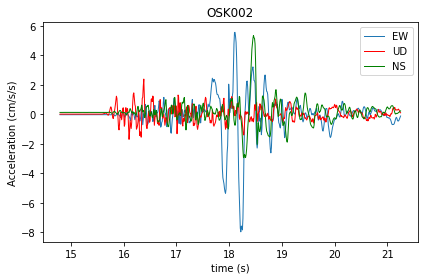

In [27]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array([(i + pw_onset -1) for i in osaka002_stream_15_to_21[0].times()])

plt.plot(x, osaka002_stream_15_to_21[0].data, label='EW', linewidth=1)
plt.plot(x, osaka002_stream_15_to_21[1].data, label='UD', linewidth=1, color='r')
plt.plot(x, osaka002_stream_15_to_21[2].data, label='NS', linewidth=1, color='g')
# Add title and labels
plt.title('OSK002')
plt.xlabel('time (s)')
plt.ylabel('Acceleration (cm/s/s)')
plt.legend()
plt.tight_layout()
save_fig("osaka002_15_to_21")
plt.show()

In [28]:
def get_input_matrix(station_name):
    """ return 13 x 100 matrix """

    data = create_station_dict(station_name, True)
    mega_features = [
        'one_sec_acc',
        'one_sec_filt_acc',
        'one_sec_abs_acc',
        'one_sec_cumabs_acc'
    ]

    input_matrix = []
    for mfeat in mega_features:
        stream = data[mfeat]
        for tr in stream:
            input_matrix.append(tr.data.tolist())

    # add geomean normalised waveform to feature
    geo_mean = geo_means[station_name]
    scaled_geo_mean = geo_mean / float(np.max(geo_mean))
    input_matrix.append(scaled_geo_mean.tolist())

    return input_matrix

def get_output_matrix(station_name):
    """ return vec of size 13 """
    #  NEAR SOURCE: 1
    #  FAR  SOURCE: 0

    data = create_station_dict(station_name, True)
    stream = data['one_sec_acc']
    trace = stream[0]
    depth = trace.stats.knet.evdp
    is_near_source = int(depth < 17)
    return [is_near_source for _ in range(13)]

In [30]:
X, y = [], []
for station in one_sec_pwave_events_streams:
    inp = get_input_matrix(station)
    outp = get_output_matrix(station)
    X.append(inp)
    y.append(outp)
data = {'X': X, 'y':y}
save_streams('TEST_ML_DATA', data)